#### This data measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

In [88]:
import os
import pandas as pd
x=os.getcwd()
print(x)

/Users/lilybug


In [127]:
path= x+'/Downloads/IPG2211A2N.csv'
data1=pd.read_csv(path)
data1.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3298
1,1939-02-01,3.3552
2,1939-03-01,3.4315
3,1939-04-01,3.4569
4,1939-05-01,3.4569


##### Right now our index is actually just a list of strings that look like a date, we’ll want to adjust these to be timestamps, that way our forecasting analysis will be able to interpret these values.

In [128]:
data1['DATE']= pd.to_datetime(data1['DATE'])

In [129]:
data1.dtypes

DATE          datetime64[ns]
IPG2211A2N           float64
dtype: object

### Visualize

<function matplotlib.pyplot.show(close=None, block=None)>

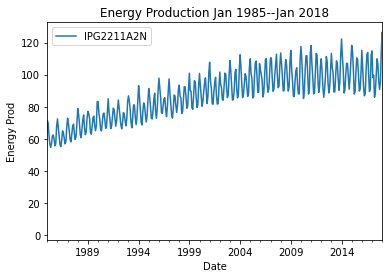

In [130]:
import matplotlib as mpl
import matplotlib.pyplot as plt
data1.plot(kind='line', x='DATE', y='IPG2211A2N')
plt.title('Energy Production Jan 1985--Jan 2018')
plt.xlabel('Date')
plt.ylabel('Energy Prod')
plt.xlim(['1985', '2018'])
#plt.ylim([40,80])
plt.show

##### Let’s also rename this column since its hard to remember what “IPG2211A2N” code stands for

In [144]:
data=data1.rename({'IPG2211A2N':'Energy Production'},axis=1).set_index('DATE')
data.tail()

,Energy Production
DATE,
2021-02-01,115.0743
2021-03-01,98.4815
2021-04-01,87.2066
2021-05-01,89.4105
2021-06-01,100.7012


## Decomposition
#### Here we can see there is an upward trend. We can use statsmodels to perform a decomposition of this time series. The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. With statsmodels we will be able to see the trend, seasonal, and residual components of our data. We can use an additive model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 100 units of energy production). A multiplicative model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of energy production everyyear).Based off the previous chart, it looks like the trend in these earlier days is slightly increasing at a higher rate than just linear (although it is a bit hard to tell from this one plot, we can always experiment with additive versus multiplicative methods.). Again, Python and Statsmodels make this task incredibly easy in just a few lines of code:

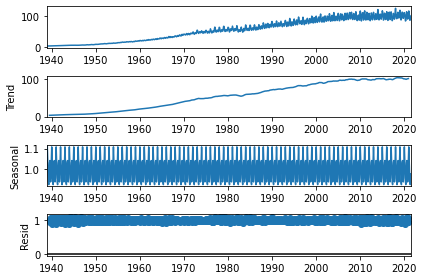

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='multiplicative')
result.plot()
plt.show()

###### Not bad for what is essentially one line of code (not counting imports and plot calls)! From the plot above we can clearly see the seasonal component of the data, and we can also see the separated upward trend of the data. Trends can be upward or downward, and can be linear or non-linear. It is important to understand your data set to know whether or not a significant period of time has passed to identify an actual trend. Irregular fluctuations are abrupt changes that are random and unpredictable.
- -----
# Auto_Arima

#### Performing the Seasonal ARIMA
###### Now that we’ve analyzed the data, we can clearly see we have a time series with a seasonal component, so it make sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component. There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc. One simple approach is to perform a grid search over multiple values of p,d,q,P,D,and Q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features. The pyramid-arima library for Python allows us to quickly perform this grid search and even creates a model object that you can fit to the training data. This library contains an auto_arima function that allows us to set a range of p,d,q,P,D,and Q values and then fit models for all the possible combinations. Then the model will keep the combination that reported back the best AIC value.

In [146]:
from pmdarima import auto_arima
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3947.623, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4450.526, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4286.278, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4060.570, Time=0.37 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3942.706, Time=0.92 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4126.879, Time=0.63 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=3912.341, Time=1.92 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=4005.532, Time=1.48 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=3899.543, Time=3.65 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=3932.435, Time=2.66 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=3993.923, Time=3.57 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=4041.361, Time=4.81 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=3901.511, Time=5.57 sec
 ARIMA(1,1,2)(2,1,2)[12]

#### The resulting best model parameters gave us an AIC value of 3901.866. We now have a model that we can fit, in order to do this , we will need training data and test data.
- - - - -- 
## Train Test Split
### We can then fit the stepwise_model object to a training data set. Because this is a time series forecast, we will “chop off” a portion of our latest data and use that as the test set. Then we will train on the rest of the data and forecast into the future. Afterwards we can compare our forecast with the section of data we chopped off. We’ll train on 20 years of data, from the years 1985–2015 and test our forecast on the years after that and compare it to the real data:

In [147]:
train = data.loc['1985-01-01':'2016-12-01']
test = data.loc['2017-01-01':]

### Train the Model - We can then train the model by simply calling .fit on the stepwise model and passing in the training data:

In [148]:
stepwise_model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

### Evaluation - Now that the model has been fitted to the training data, we can forecast into the future. Recall that our test data set is from 2015–01–01 all the way to 2018–01–01. So if we check the length of our test data we get 37 rows, or 37 time periods. That is the value we will use for our .predict() method call:

In [149]:
future_forecast = stepwise_model.predict(n_periods=len(test))
# This returns an array of predictions:
print(future_forecast)

[119.65496616 108.04345601  98.33311566  88.6248694   90.40821793
 101.72941755 111.70479747 110.82892046  99.33337233  90.28335329
  94.2134118  110.01750263 118.83369174 108.94593471 100.07195404
  88.86959509  90.8392073  101.61331641 111.26912454 109.86705673
  99.48539365  90.68346125  95.09276726 108.47994628 118.75136715
 109.46842416 100.23651922  88.9118764   90.7612851  101.80515467
 111.40613597 110.25677799 100.1489477   90.89687154  94.99330429
 108.28816975 119.09376765 109.71970686 100.02490454  89.03728521
  90.75757051 102.12702378 111.78166665 110.94113289 100.69939887
  91.08896462  94.85095722 108.75892854 119.50299278 109.90209185
 100.00934178  89.27236891  90.94310264 102.44677348]


### Let’s reorganize this set of predictions by creating a dataframe that contains our future forecast and then concatenating that with the original data. We can then plot this to view how well our prediction forecast matched up with the test set for which we have the real data:

In [150]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
Combine_data=pd.concat([test,future_forecast],axis=1)
Combine_data.tail()

,Energy Production,Prediction
DATE,,
2021-02-01,115.0743,109.902092
2021-03-01,98.4815,100.009342
2021-04-01,87.2066,89.272369
2021-05-01,89.4105,90.943103
2021-06-01,100.7012,102.446773


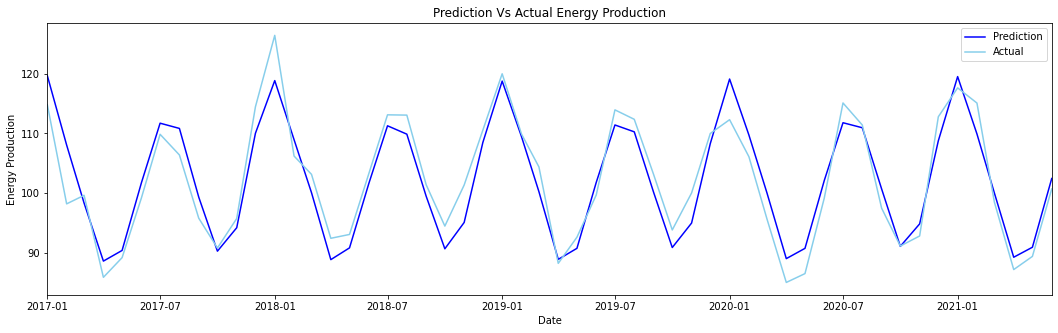

In [155]:
# plot forecast results and display RMSE

plt.figure(figsize=(18,5))
plt.plot(Combine_data['Prediction'], 'b', label="Prediction");
plt.plot(test,'skyblue',label="Actual");
plt.xlabel("Date")
plt.ylabel("Energy Production")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.title("Prediction Vs Actual Energy Production")
plt.show()

### We can also just compare this to the entire data set to get a larger picture of the context of our prediction.

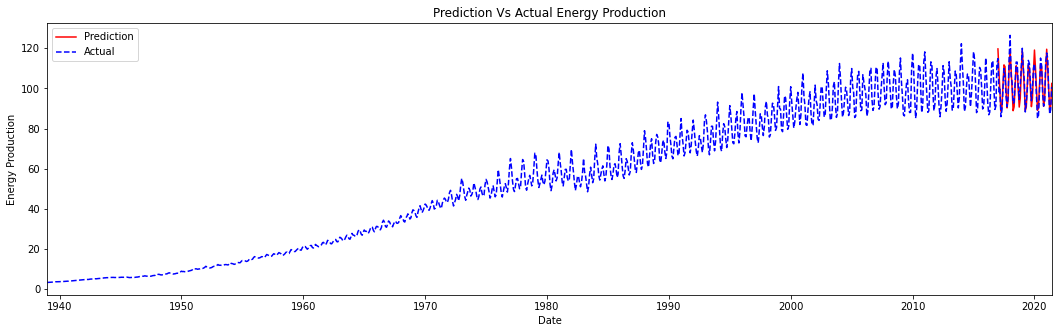

In [162]:
# plot forecast results and display RMSE

plt.figure(figsize=(18,5))
plt.plot(Combine_data['Prediction'], 'r', label="Prediction");
plt.plot(data,'blue',label="Actual", linestyle='dashed');
plt.xlabel("Date")
plt.ylabel("Energy Production")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.title("Prediction Vs Actual Energy Production")
plt.show()

In [163]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(test,future_forecast))
print(rms)

3.4799006727893675


### Next Steps
#### Now that we’ve evaluated our data on the test set and our satisfied with the performance, the next step would be to refit our model to our entire data set and then forecast into the real future

/Users/lilybug/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lilybug/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


DATE
1939-01-01    0.000000
1939-02-01    3.329798
1939-03-01    3.355198
1939-04-01    3.431500
1939-05-01    3.456900
1939-06-01    3.456900
1939-07-01    3.507700
1939-08-01    3.507700
1939-09-01    3.558600
1939-10-01    3.660200
dtype: float64


Text(0.5, 1.0, 'Plot showing Prediction, Actual and 60 day Forecast')

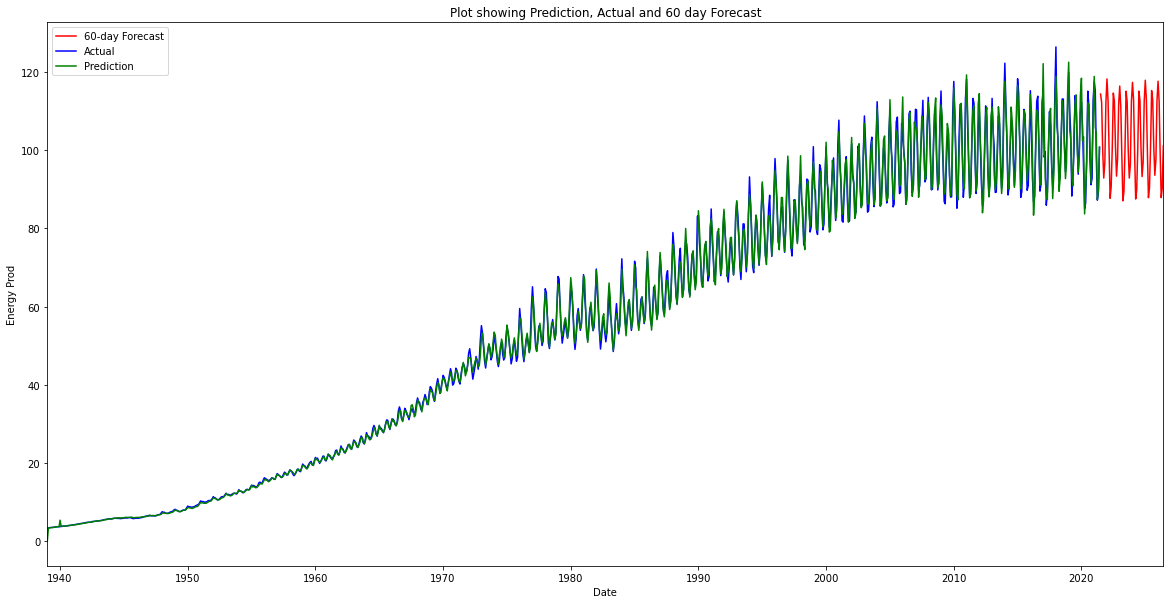

In [169]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(data,order=(3,1,1),seasonal_order=(2, 1, 0, 12))

# Extract fitted model

model_fit=model.fit(disp=False)

# Calculate residuals on original series
prediction=pd.Series(model_fit.fittedvalues, copy=True)

print(prediction.head(10))

# Compute Residuals and check residual plot
residual=prediction-data

#plt.figure(figsize=(20,10))
#plt.plot(residual, 'o')


#r,q,p = sm.tsa.acf(resid20.values.squeeze(), qstat=True)
#data = np.c_[range(1,41), r[1:], q, p]
#table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
#print table.set_index('lag')


# Make 15 day prediction
K=60
forecast=model_fit.forecast(K)

#print(forecast)

# plot forecast results and display RMSE

plt.figure(figsize=(20,10))
plt.plot(forecast, 'r',label="60-day Forecast");
plt.plot(data,'b',label="Actual");
plt.plot(prediction,'g',label="Prediction");
plt.xlabel("Date")
plt.ylabel("Energy Prod")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.title("Plot showing Prediction, Actual and 60 day Forecast")